In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

In [ ]:

# Load ECG Dataset
ecg_data = fetch_openml(name="ECG5000", version=1, as_frame=False)
X, y = ecg_data['data'], ecg_data['target'].astype(int)

# Use a smaller subset of the data
X = X[:500]
y = y[:500]

# Binary classification: class 1 vs others
y = (y == 1).astype(int).reshape(-1, 1)

# Normalize input features
X = StandardScaler().fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Activation Functions

def sigmoid(x): return 1 / (1 + np.exp(-x))
def sigmoid_deriv(x): return sigmoid(x) * (1 - sigmoid(x))

def tanh(x): return np.tanh(x)
def tanh_deriv(x): return 1 - np.tanh(x)**2

def relu(x): return np.maximum(0, x)
def relu_deriv(x): return (x > 0).astype(float)

def leaky_relu(x, alpha=0.01): return np.where(x > 0, x, alpha * x)
def leaky_relu_deriv(x, alpha=0.01): return np.where(x > 0, 1, alpha)

def elu(x, alpha=1): return np.where(x >= 0, x, alpha * (np.exp(x) - 1))
def elu_deriv(x, alpha=1): return np.where(x >= 0, 1, alpha * np.exp(x))

def selu(x, lam=1.0507, alpha=1.6732): return lam * elu(x, alpha)
def selu_deriv(x, lam=1.0507, alpha=1.6732): return lam * elu_deriv(x, alpha)

def prelu(x, a=0.25): return np.where(x >= 0, x, a * x)
def prelu_deriv(x, a=0.25): return np.where(x >= 0, 1, a)

activation_functions = {
    "sigmoid": (sigmoid, sigmoid_deriv),
    "tanh": (tanh, tanh_deriv),
    "relu": (relu, relu_deriv),
    "leaky_relu": (leaky_relu, leaky_relu_deriv),
    "elu": (elu, elu_deriv),
    "selu": (selu, selu_deriv),
    "prelu": (prelu, prelu_deriv),
}


In [ ]:
# Loss and Accuracy

def binary_cross_entropy(y_true, y_pred):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def accuracy(y_true, y_pred):
    return np.mean((y_pred > 0.5).astype(int) == y_true)


In [ ]:
# Simple ANN Model

class SimpleANN:
    def __init__(self, input_size, hidden_size, output_size, activation="relu"):
        self.activation, self.activation_deriv = activation_functions[activation]
        self.w1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros((1, hidden_size))
        self.w2 = np.random.randn(hidden_size, output_size) * 0.1
        self.b2 = np.zeros((1, output_size))

    def forward(self, X):
        self.z1 = X @ self.w1 + self.b1
        self.a1 = self.activation(self.z1)
        self.z2 = self.a1 @ self.w2 + self.b2
        self.a2 = sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, lr):
        m = y.shape[0]
        y_pred = self.forward(X)
        dz2 = y_pred - y
        dw2 = self.a1.T @ dz2 / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        da1 = dz2 @ self.w2.T
        dz1 = da1 * self.activation_deriv(self.z1)
        dw1 = X.T @ dz1 / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.w2 -= lr * dw2
        self.b2 -= lr * db2
        self.w1 -= lr * dw1
        self.b1 -= lr * db1

In [ ]:
# Training Function

def train(model, X, y, X_val, y_val, epochs=200, lr=0.1, optimizer="gd", batch_size=32):
    acc_hist, loss_hist = [], []
    for epoch in range(epochs):
        if optimizer == "gd":
            model.backward(X, y, lr)
        elif optimizer == "sgd":
            for i in range(X.shape[0]):
                model.backward(X[i:i+1], y[i:i+1], lr)
        elif optimizer == "mini-batch":
            for i in range(0, X.shape[0], batch_size):
                xb = X[i:i+batch_size]
                yb = y[i:i+batch_size]
                model.backward(xb, yb, lr)

        y_pred_val = model.forward(X_val)
        acc_hist.append(accuracy(y_val, y_pred_val))
        loss_hist.append(binary_cross_entropy(y_val, y_pred_val))

    final_acc = acc_hist[-1]
    final_loss = loss_hist[-1]
    return final_acc, final_loss, acc_hist, loss_hist

In [ ]:
# Run All Combinations

activations = list(activation_functions.keys())
optimizers = ["gd", "sgd", "mini-batch"]
results = []
history = {}

for act in activations:
    for opt in optimizers:
        # The input_size should match the number of features in X_train
        # X_train.shape[1] gives the number of features/columns
        model = SimpleANN(input_size=X_train.shape[1], hidden_size=8, output_size=1, activation=act)
        acc, loss, acc_hist, loss_hist = train(model, X_train, y_train, X_test, y_test, optimizer=opt)
        results.append({
            "Activation": act,
            "Optimizer": opt,
            "Final Accuracy (%)": round(acc * 100, 2),
            "Final Loss": round(loss, 4)
        })
        key = f"{act}_{opt}"
        history[key] = {"acc": acc_hist, "loss": loss_hist}

<ipython-input-3-30ea5f6f5bfb>:3: RuntimeWarning: overflow encountered in exp
  def sigmoid(x): return 1 / (1 + np.exp(-x))
<ipython-input-3-30ea5f6f5bfb>:15: RuntimeWarning: overflow encountered in exp
  def elu(x, alpha=1): return np.where(x >= 0, x, alpha * (np.exp(x) - 1))
<ipython-input-3-30ea5f6f5bfb>:16: RuntimeWarning: overflow encountered in exp
  def elu_deriv(x, alpha=1): return np.where(x >= 0, 1, alpha * np.exp(x))
<ipython-input-3-30ea5f6f5bfb>:15: RuntimeWarning: overflow encountered in multiply
  def elu(x, alpha=1): return np.where(x >= 0, x, alpha * (np.exp(x) - 1))
<ipython-input-3-30ea5f6f5bfb>:16: RuntimeWarning: overflow encountered in multiply
  def elu_deriv(x, alpha=1): return np.where(x >= 0, 1, alpha * np.exp(x))


In [ ]:
# Final Summary Table
df = pd.DataFrame(results)
df_sorted = df.sort_values(by="Final Accuracy (%)", ascending=False).reset_index(drop=True)
print("Best Activation Function + Optimizer Combinations:")
print(df_sorted.to_string(index=False))


Best Activation Function + Optimizer Combinations:
Activation  Optimizer  Final Accuracy (%)  Final Loss
      tanh mini-batch                98.0      0.1193
      selu         gd                98.0      0.1114
      selu mini-batch                98.0      0.2683
       elu         gd                98.0      0.1318
   sigmoid         gd                97.0      0.1306
     prelu        sgd                97.0      0.8289
      tanh        sgd                97.0      0.1930
   sigmoid mini-batch                97.0      0.1336
   sigmoid        sgd                97.0      0.1741
       elu        sgd                97.0      0.6008
       elu mini-batch                97.0      0.2090
leaky_relu        sgd                97.0      0.6468
     prelu mini-batch                97.0      0.2868
      tanh         gd                96.0      0.1256
      relu         gd                96.0      0.1570
      relu mini-batch                96.0      0.2514
leaky_relu         gd          

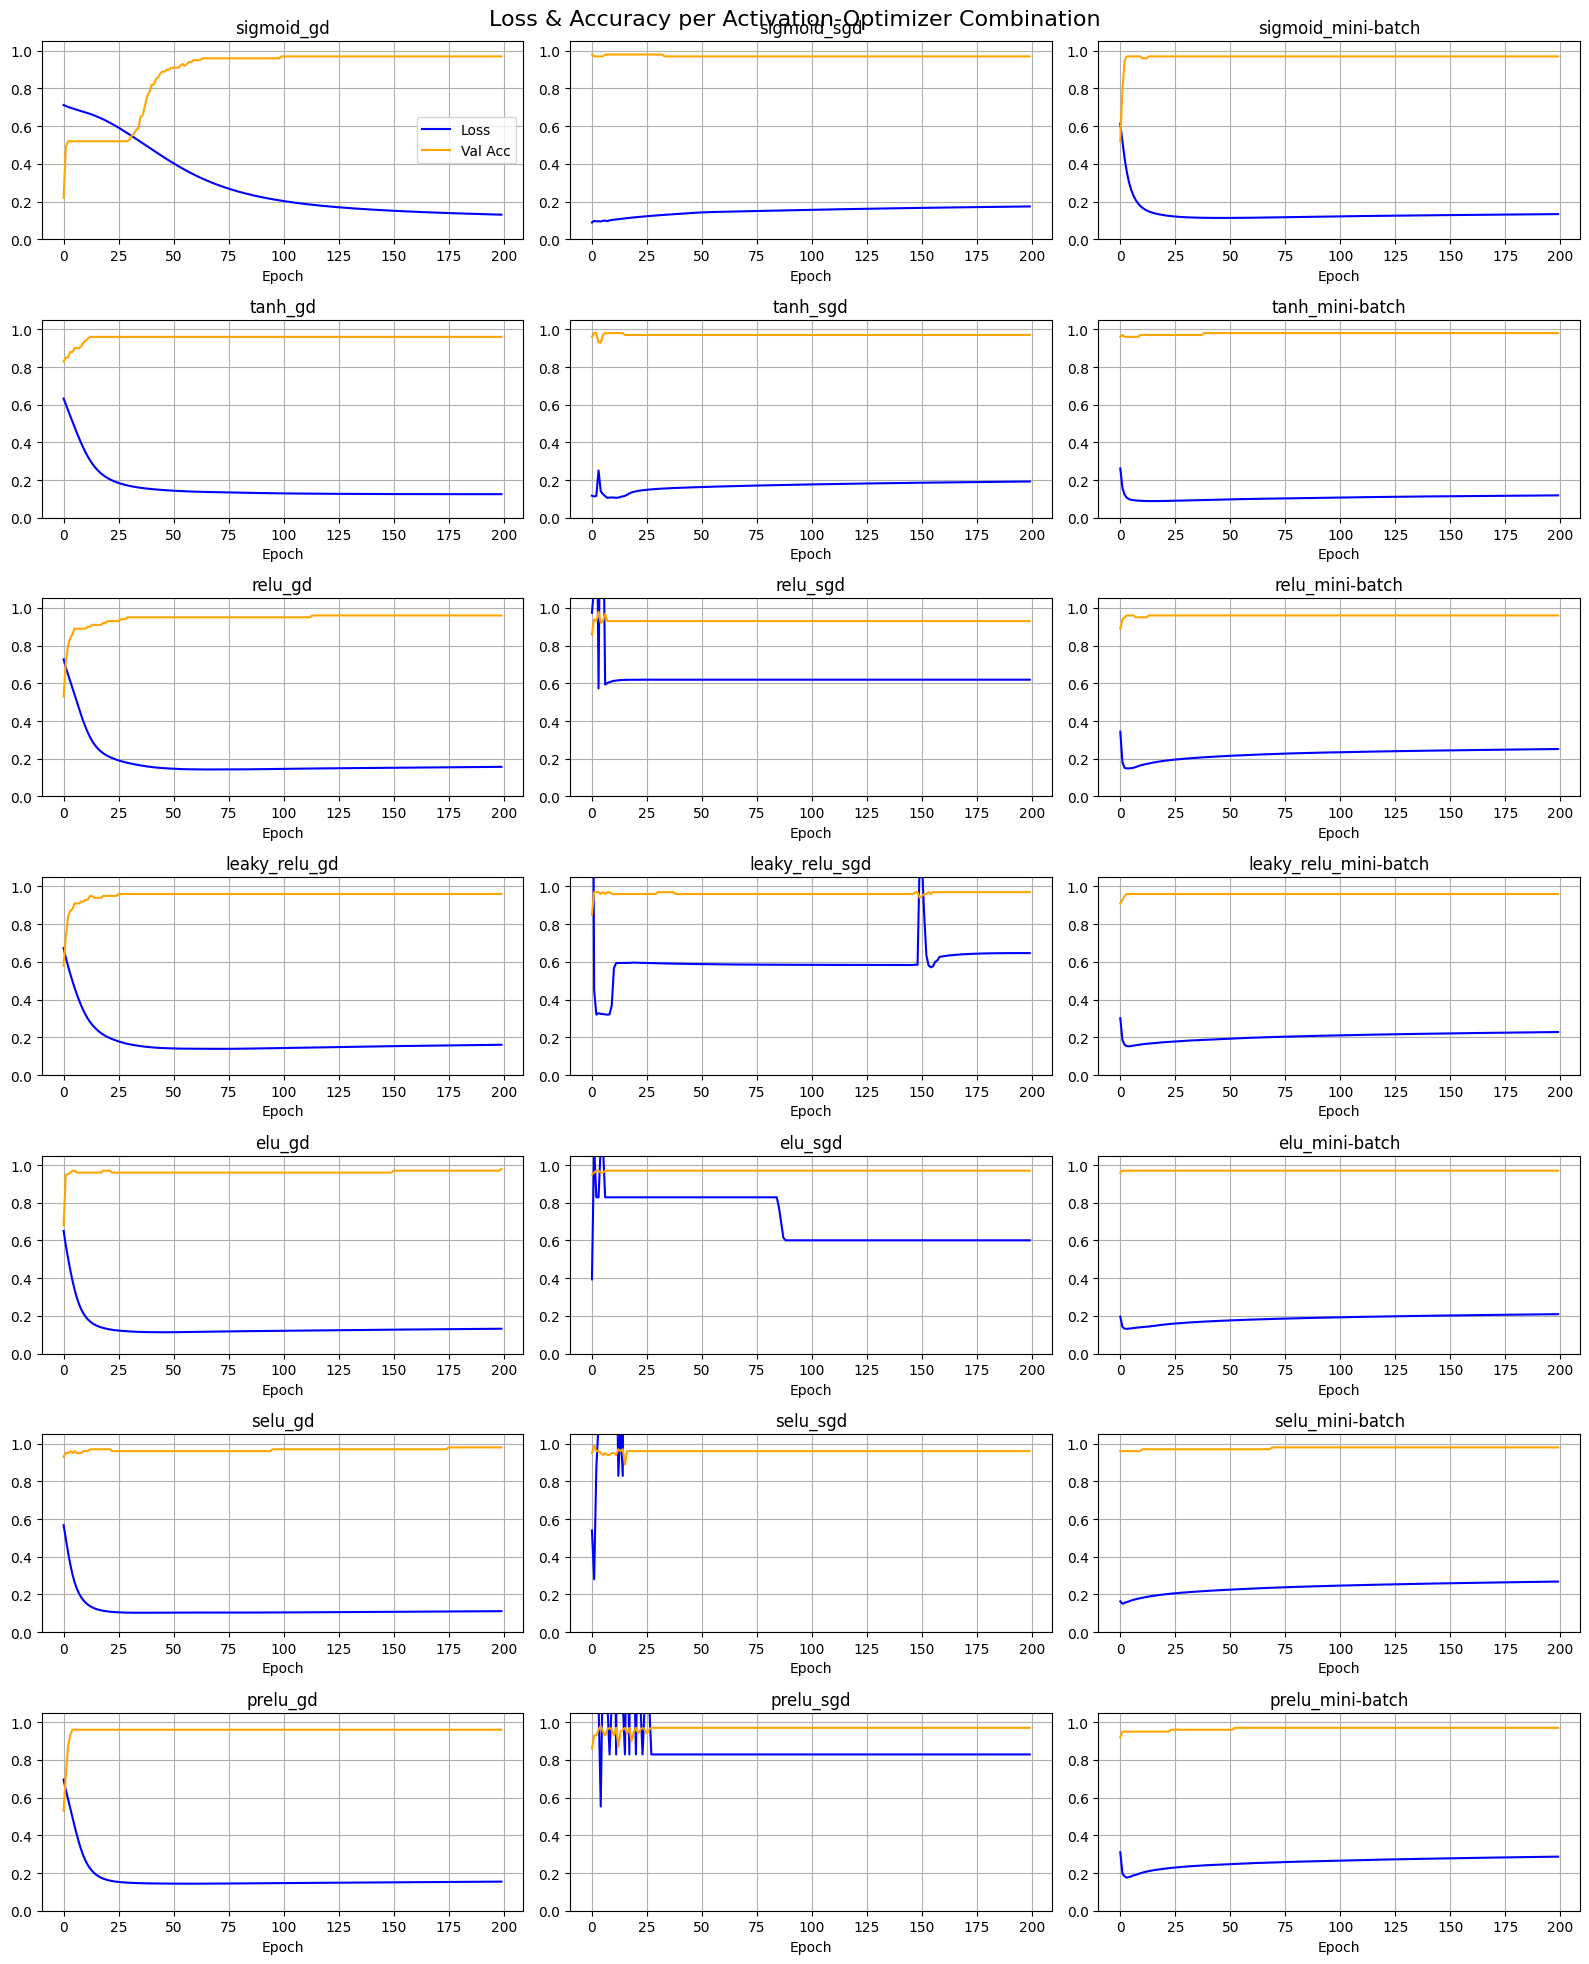

In [ ]:
# visualization

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(16, 20))
axs = axs.flatten()

for i, (key, val) in enumerate(history.items()):
    axs[i].plot(val["loss"], label="Loss", color='blue')
    axs[i].plot(val["acc"], label="Val Acc", color='orange')
    axs[i].set_title(key)
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylim(0, 1.05)
    axs[i].grid(True)
    if i == 0:
        axs[i].legend()

plt.suptitle("Loss & Accuracy per Activation-Optimizer Combination", fontsize=16)
plt.tight_layout()
plt.show()

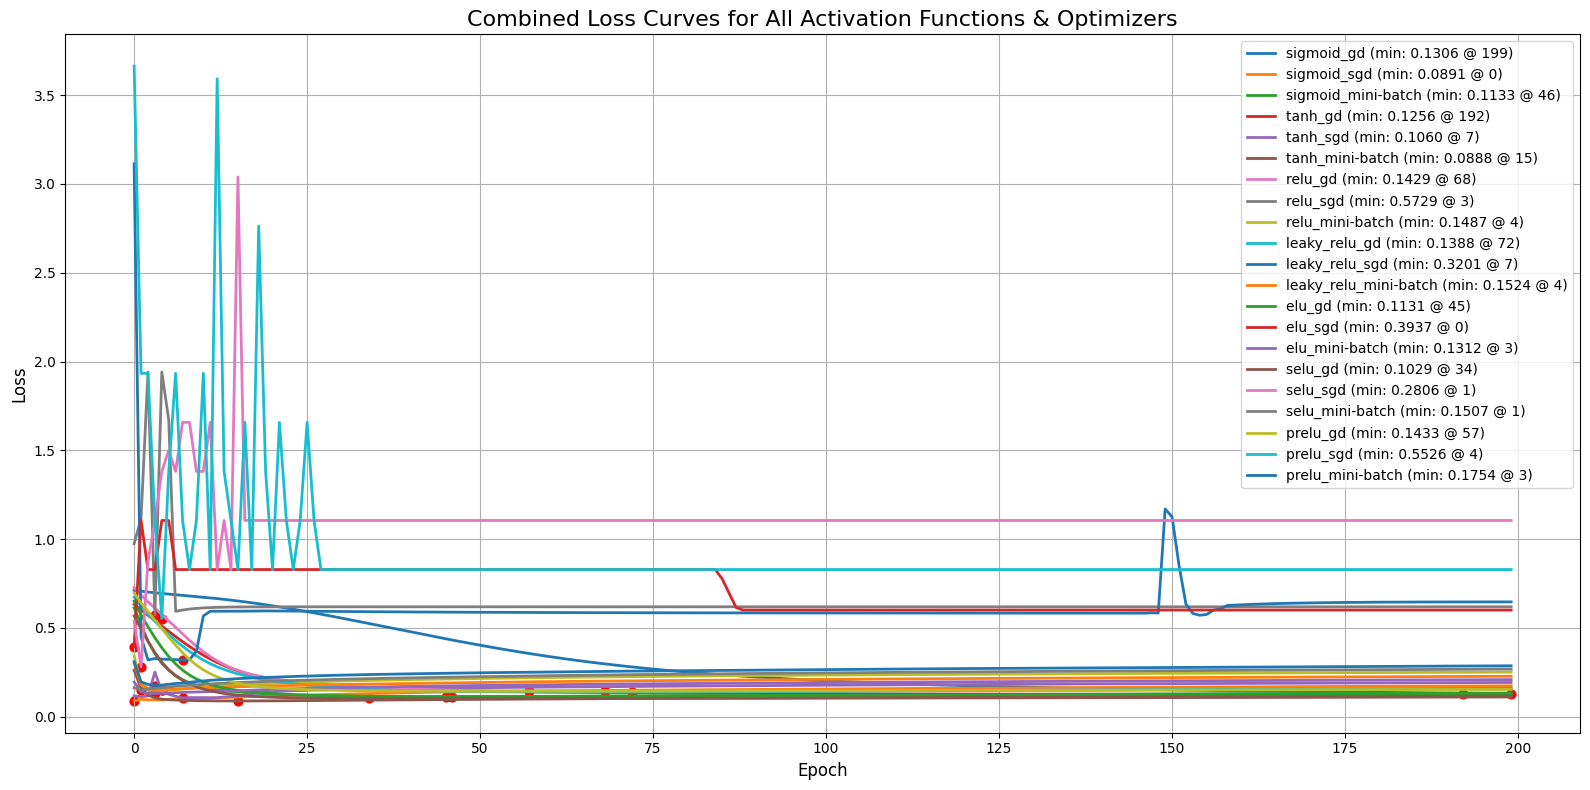

In [ ]:
# Combined loss curves for all activation functions and optimizers
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# Loop over each combination in history
for key, metrics in history.items():
    losses = metrics["loss"]
    epochs = list(range(len(losses)))

    # Find global minimum
    min_loss = min(losses)
    min_epoch = losses.index(min_loss)

    # Plot loss curve
    plt.plot(epochs, losses, label=f"{key} (min: {min_loss:.4f} @ {min_epoch})", linewidth=2)

    # Mark the global minimum
    plt.scatter(min_epoch, min_loss, color='red', s=40)

# Labels and formatting
plt.title("Combined Loss Curves for All Activation Functions & Optimizers", fontsize=16)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()
